In [1]:
import pandas as pd
import numpy as np
import pkg_resources
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
import devanalyst
import devanalyst.simulation.GenerateTimecards as timecard
import devanalyst.simulation.tests.test_utils as tu_
from devanalyst.simulation.simulationModels import ModelsConfig, DefaultCostModel, GreedyAllocationModel, Random, \
BalancedAllocationModel
import devanalyst.simulation.simulationModels as simm

In [32]:
USER_STORIES = None

In [33]:
def loadSampleUserStories():
    global USER_STORIES
    resource_path = '/'.join(('resources', 'tests', 'simulation', 'test_userStoryCreate.stories_df_EXPECTED.csv'))
    resource_package = 'devanalyst'
    fullpath = pkg_resources.resource_filename(resource_package, resource_path)
        
    USER_STORIES = pd.read_csv(fullpath)
    USER_STORIES.drop(['Unnamed: 0'], axis='columns', inplace=True)

    
loadSampleUserStories()

In [34]:
USER_STORIES[:5]

,User Story Id,Scrum Team,Product Manager,Developer,Estimate
0,UserStory #1,Team A,Sherlyn Cordle,Beau Hockensmith,10
1,UserStory #2,Team A,Sherlyn Cordle,Glenna Mcghie,10
2,UserStory #3,Team A,Edgar Hibbler,Francisco Hoppe,4
3,UserStory #4,Team A,Sherlyn Cordle,Beau Hockensmith,7
4,UserStory #5,Team A,Edgar Hibbler,Gregorio Darr,3


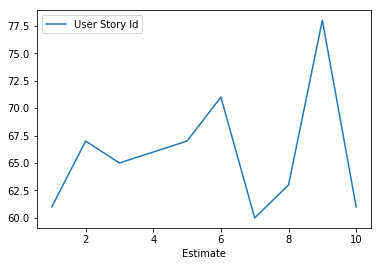

In [35]:
#USER_STORIES[USER_STORIES['Scrum Team']=='Team A'].groupby(['Estimate']).count().plot()
dist = USER_STORIES.groupby(['Estimate']).count()
dist.drop(['Scrum Team','Product Manager','Developer'], axis='columns', inplace=True)
dist.plot()

In [36]:
dist

,User Story Id
Estimate,
1,61
2,67
3,65
4,66
5,67
6,71
7,60
8,63
9,78


In [37]:
d =dist['User Story Id']
d.mean(), d.min(), d.max()

(65.9, 60, 78)

In [38]:
r = Random()
data = {'Estimate': [], 'Story': []}
for i in range(250):
    data['Estimate'].append(r.pickHowLong(10))
    data['Story'].append('Story ' + str(i))
df = pd.DataFrame(data)
df[:5]

,Estimate,Story
0,9,Story 0
1,4,Story 1
2,2,Story 2
3,4,Story 3
4,5,Story 4


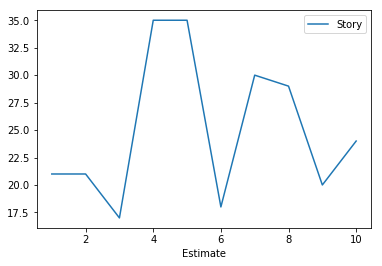

In [39]:
df.groupby(['Estimate']).count().plot()

In [40]:
sample = USER_STORIES['Estimate']
sample.mean(), sample.std(), sample.count()

(5.5402124430956, 2.85508248627453, 659)

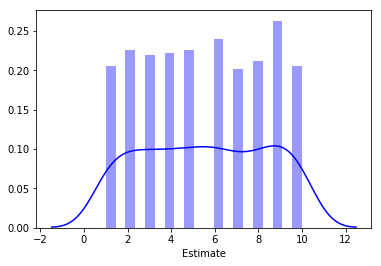

In [41]:
sns.distplot(sample, bins=20, color='b')

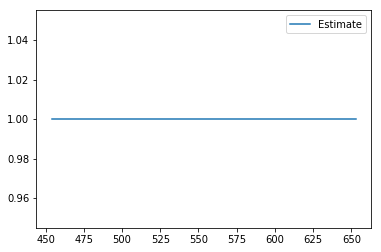

In [42]:
x = USER_STORIES[USER_STORIES['Estimate']==1]
x[x['Scrum Team']=='Team D'].plot()

In [43]:
TIMECARD = None

In [44]:
def loadSampleTimecard():
    global TIMECARD
    resource_path = '/'.join(('resources', 'tests', 'simulation', 'test_releaseCycle.Entries_EXPECTED.csv'))
    resource_package = 'devanalyst'
    fullpath = pkg_resources.resource_filename(resource_package, resource_path)
        
    TIMECARD = pd.read_csv(fullpath)
    # Replace string representation of dates by actual dates
    TIMECARD['Date'] = TIMECARD['Date'].apply(lambda x: pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')).date()) 
    TIMECARD.drop(['Unnamed: 0'], axis='columns', inplace=True)

    
loadSampleTimecard()

In [45]:
TIMECARD[:5]

,Sprint,Date,Team,Developer,User Story,Task Type,Time Spent
0,1,2018-01-29,Team A,Anton Easterday,UserStory #151,UNFINISHED_STORIES,2.5
1,1,2018-01-29,Team A,Anton Easterday,UserStory #97,UNFINISHED_STORIES,2.5
2,1,2018-01-29,Team A,Anton Easterday,UserStory #58,UNFINISHED_STORIES,5.0
3,1,2018-01-29,Team A,Anton Easterday,UserStory #83,UNFINISHED_STORIES,0.0
4,1,2018-01-29,Team A,Beau Hockensmith,UserStory #1,UNFINISHED_STORIES,10.0


In [46]:
SPRINT_DURATION = 10

In [47]:
def storyInfo(group_df):
    info = {}
    
    #Go back, as min['Date'] is end of first sprint
    info['Start'] = [timecard.subtractBusinessDays(group_df['Date'].min(), SPRINT_DURATION)] 
    info['End'] = [group_df['Date'].max()]
    info['Elapsed Time'] = (info['End'][0] - info['Start'][0]).days
    info['Effort'] = group_df['Time Spent'].sum()
    info['Initial Sprint'] = [group_df['Sprint'].min()]
    info['Final Sprint'] = [group_df['Sprint'].max()]  
    
    return pd.DataFrame(info)

In [48]:
def sprintInfo(group_df):
    info = {}
    
    info['Effort'] = group_df['Effort'].sum()
    info['Avg Effort'] = group_df['Effort'].mean()
    info['Stories Completed'] = [group_df['User Story'].count()]
    info['Over 1 sprint'] = [group_df[group_df['Elapsed Time']==14]['User Story'].count()]
    info['Over 2 sprint'] = [group_df[group_df['Elapsed Time']==28]['User Story'].count()]
    info['Over 3 sprint'] = [group_df[group_df['Elapsed Time']==42]['User Story'].count()]
    info['Over 4 sprint'] = [group_df[group_df['Elapsed Time']==56]['User Story'].count()]
 
    
    return pd.DataFrame(info)

In [49]:
def genBurnout(entries_df):
    bystory = entries_df.groupby('User Story')
    u = bystory.apply(storyInfo)
    u = u.reset_index()
    u.drop(['level_1'], axis='columns', inplace=True)
    s = u.groupby('Final Sprint')
    burnout = s.apply(sprintInfo)
    burnout = burnout.reset_index()
    burnout.drop(['level_1'], axis='columns', inplace=True)
    return burnout, u

In [50]:
burn1, u1 = genBurnout(TIMECARD)

In [51]:
u1[:5]

,User Story,Start,End,Elapsed Time,Effort,Initial Sprint,Final Sprint
0,UserStory #1,2018-01-15,2018-02-12,28,12.50,1,2
1,UserStory #10,2018-06-04,2018-07-16,42,11.25,11,13
2,UserStory #100,2018-02-12,2018-03-12,28,10.00,3,4
3,UserStory #101,2018-06-18,2018-07-30,42,11.25,12,14
4,UserStory #102,2018-06-18,2018-07-02,14,7.50,12,12


In [52]:
burn1

,Final Sprint,Effort,Avg Effort,Stories Completed,Over 1 sprint,Over 2 sprint,Over 3 sprint,Over 4 sprint
0,1,160.00,5.000000,32,32,0,0,0
1,2,356.25,4.567308,78,36,42,0,0
2,3,252.50,4.208333,60,21,39,0,0
3,4,308.75,5.145833,60,19,41,0,0
4,5,288.75,5.156250,56,14,40,2,0
5,6,307.50,6.275510,49,21,23,4,1
6,7,308.75,6.569149,47,12,29,6,0
7,8,218.75,6.835938,32,8,23,1,0
8,9,330.00,8.461538,39,8,19,10,2
9,10,317.50,8.581081,37,6,22,8,1


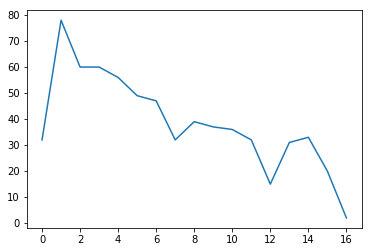

In [54]:
burn1['Stories Completed'].plot()

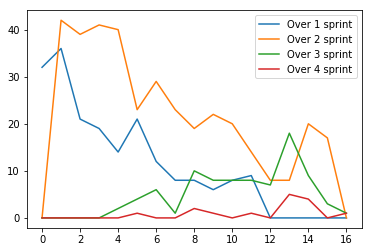

In [55]:
burn1[['Over 1 sprint', 'Over 2 sprint', 'Over 3 sprint', 'Over 4 sprint']].plot()

In [56]:
class SimpleModel:

    #
    # -slippage: a number corresponding to the percentage by which estimates differ from actuals. A 25% difference
    # corresponds to slippage of 0.25
    def __init__(self, slippage):
        self.slippage = slippage
        return
    
    # TODO - dummy implementation for now
    def runModel(self, item):
        DELAY = self.slippage   
        return 1 + DELAY

In [61]:
# Test logic
def genReleaseCycle(modelsConfig):
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    
    tu_.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = tu_.initTestData(tu_.DEV_DF, \
                                                                                           tu_.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    
    NUMBER_OF_SPRINTS = 25

    entries_df, worksheets = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    return entries_df, worksheets

In [62]:
modelsConfig = ModelsConfig([DefaultCostModel(0.0)], [], GreedyAllocationModel(SPRINT_DURATION)) 
modelsConfig.random.reset(271)
entries_df, worksheets = genReleaseCycle(modelsConfig)

In [83]:
modelsConfig_bal = ModelsConfig([DefaultCostModel(0.0)], [], BalancedAllocationModel(SPRINT_DURATION)) 
modelsConfig_bal.random.reset(271)
entries_bal_df, worksheets_bal = genReleaseCycle(modelsConfig_bal)

In [63]:
entries_df[:5]

,Sprint,Date,Team,Developer,User Story,Task Type,Time Spent
0,1,2018-01-29,Team A,Anton Easterday,UserStory #151,UNFINISHED_STORIES,2.0
1,1,2018-01-29,Team A,Anton Easterday,UserStory #97,UNFINISHED_STORIES,2.0
2,1,2018-01-29,Team A,Anton Easterday,UserStory #58,UNFINISHED_STORIES,4.0
3,1,2018-01-29,Team A,Anton Easterday,UserStory #83,UNFINISHED_STORIES,2.0
4,1,2018-01-29,Team A,Beau Hockensmith,UserStory #1,UNFINISHED_STORIES,10.0


In [64]:
burn2, u2 = genBurnout(entries_df)

In [65]:
u2[:5]

,User Story,Start,End,Elapsed Time,Effort,Initial Sprint,Final Sprint
0,UserStory #1,2018-01-15,2018-01-29,14,10.0,1,1
1,UserStory #10,2018-03-12,2018-04-09,28,9.0,5,6
2,UserStory #100,2018-04-09,2018-04-23,14,8.0,7,7
3,UserStory #101,2018-03-12,2018-03-26,14,9.0,5,5
4,UserStory #102,2018-03-12,2018-03-26,14,6.0,5,5


In [66]:
burn2

,Final Sprint,Effort,Avg Effort,Stories Completed,Over 1 sprint,Over 2 sprint,Over 3 sprint,Over 4 sprint
0,1,300.0,4.054054,74,74,0,0,0
1,2,300.0,3.947368,76,76,0,0,0
2,3,298.0,4.257143,70,70,0,0,0
3,4,298.0,4.656250,64,62,2,0,0
4,5,289.0,4.982759,58,54,4,0,0
5,6,301.0,6.270833,48,35,13,0,0
6,7,285.0,5.937500,48,36,12,0,0
7,8,298.0,6.208333,48,31,17,0,0
8,9,300.0,6.382979,47,27,20,0,0
9,10,281.0,7.205128,39,22,17,0,0


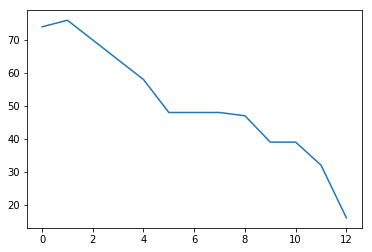

In [67]:
burn2['Stories Completed'].plot()

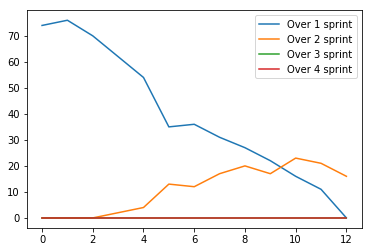

In [68]:
burn2[['Over 1 sprint', 'Over 2 sprint', 'Over 3 sprint', 'Over 4 sprint']].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x27c3f1746a0>,
 <matplotlib.legend.Legend at 0x27c3effc4a8>)

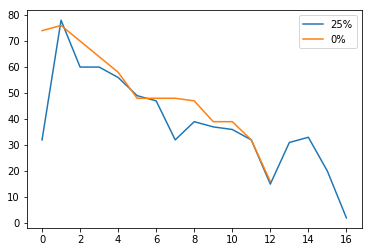

In [69]:
burn1['Stories Completed'].plot(label = '25%'), burn2['Stories Completed'].plot(label = '0%'), plt.legend()

(<matplotlib.axes._subplots.AxesSubplot at 0x27c3f16a828>,
 <matplotlib.legend.Legend at 0x27c3effc550>)

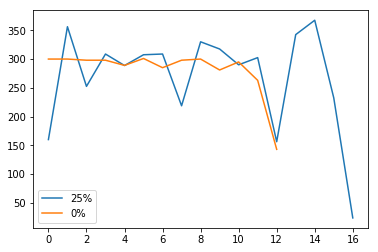

In [70]:
burn1['Effort'].plot(label = '25%'), burn2['Effort'].plot(label = '0%'), plt.legend()

(<matplotlib.axes._subplots.AxesSubplot at 0x27c3f07f048>,
 <matplotlib.legend.Legend at 0x27c3f058be0>)

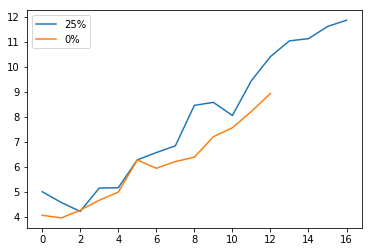

In [71]:
burn1['Avg Effort'].plot(label = '25%'), burn2['Avg Effort'].plot(label = '0%'), plt.legend()

In [72]:
worksheets[:5]

,Sprint,Team,Work Sheet,Unplanned Backlog
0,1,Team A,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...
1,1,Team B,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...
2,1,Team C,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...
3,1,Team D,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...
4,2,Team A,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...


In [73]:
sheet = worksheets['Work Sheet'][0]

In [74]:
sheet.committedTime(10)

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth
0,Anton Easterday,0.0,0,0.0,0,0.0,4,10.0,0.0,0,20.0
1,Beau Hockensmith,0.0,0,0.0,0,0.0,1,10.0,0.0,0,20.0
2,Bruno Studley,0.0,0,0.0,0,0.0,3,10.0,0.0,0,20.0
3,Craig Garlitz,0.0,0,0.0,0,0.0,2,10.0,0.0,0,20.0
4,Francisco Hoppe,0.0,0,0.0,0,0.0,2,10.0,0.0,0,20.0
5,Glenna Mcghie,0.0,0,0.0,0,0.0,2,10.0,0.0,0,20.0
6,Gregorio Darr,0.0,0,0.0,0,0.0,3,10.0,0.0,0,20.0
7,Heriberto Martini,0.0,0,0.0,0,0.0,2,10.0,0.0,0,20.0
8,OWNER_TBD,0.0,0,0.0,0,898.0,166,NaN,0.0,0,0.0


In [75]:
sheet.committedTasks()

,Owner,Task Type,User Story Id,Planned for Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,UNFINISHED_STORIES,UserStory #151,1,2.0,CURRENT_SPRINT,2.0,0.0,1
1,Anton Easterday,UNFINISHED_STORIES,UserStory #97,1,2.0,CURRENT_SPRINT,2.0,0.0,1
2,Anton Easterday,UNFINISHED_STORIES,UserStory #58,1,4.0,CURRENT_SPRINT,4.0,0.0,1
3,Anton Easterday,UNFINISHED_STORIES,UserStory #83,1,2.0,CURRENT_SPRINT,2.0,0.0,1
4,Beau Hockensmith,UNFINISHED_STORIES,UserStory #1,1,10.0,CURRENT_SPRINT,10.0,0.0,1
5,Bruno Studley,UNFINISHED_STORIES,UserStory #77,1,3.0,CURRENT_SPRINT,3.0,0.0,1
6,Bruno Studley,UNFINISHED_STORIES,UserStory #137,1,2.0,CURRENT_SPRINT,2.0,0.0,1
7,Bruno Studley,UNFINISHED_STORIES,UserStory #52,1,5.0,CURRENT_SPRINT,5.0,0.0,1
8,Craig Garlitz,UNFINISHED_STORIES,UserStory #143,1,9.0,CURRENT_SPRINT,9.0,0.0,1
9,Craig Garlitz,UNFINISHED_STORIES,UserStory #75,1,1.0,CURRENT_SPRINT,1.0,0.0,1


In [76]:
worksheets['Work Sheet'][3].committedTasks()

,Owner,Task Type,User Story Id,Planned for Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Mohammad Tineo,UNFINISHED_STORIES,UserStory #644,1,6.0,CURRENT_SPRINT,6.0,0.0,1
1,Mohammad Tineo,UNFINISHED_STORIES,UserStory #628,1,3.0,CURRENT_SPRINT,3.0,0.0,1
2,Mohammad Tineo,UNFINISHED_STORIES,UserStory #606,1,1.0,CURRENT_SPRINT,1.0,0.0,1
3,Nohemi Santini,UNFINISHED_STORIES,UserStory #613,1,7.0,CURRENT_SPRINT,7.0,0.0,1
4,Nohemi Santini,UNFINISHED_STORIES,UserStory #563,1,3.0,CURRENT_SPRINT,3.0,0.0,1
5,Olevia Haymaker,UNFINISHED_STORIES,UserStory #500,1,9.0,CURRENT_SPRINT,9.0,0.0,1
6,Olevia Haymaker,UNFINISHED_STORIES,UserStory #565,1,1.0,CURRENT_SPRINT,1.0,0.0,1
7,Pedro Sisk,UNFINISHED_STORIES,UserStory #566,1,4.0,CURRENT_SPRINT,4.0,0.0,1
8,Pedro Sisk,UNFINISHED_STORIES,UserStory #576,1,6.0,CURRENT_SPRINT,6.0,0.0,1
9,Percy Aumiller,UNFINISHED_STORIES,UserStory #642,1,5.0,CURRENT_SPRINT,5.0,0.0,1


In [77]:
u2[u2['Elapsed Time']==42].count()

User Story        0
Start             0
End               0
Elapsed Time      0
Effort            0
Initial Sprint    0
Final Sprint      0
dtype: int64

In [78]:
burn1.equals(burn2)

False

In [79]:
u1.equals(u2)

False

In [80]:
entries_df.equals(TIMECARD)

False